<a href="https://colab.research.google.com/github/eugeniepatard/DeepLearning/blob/main/cnn_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recognizing Male and Female in a Celebrity Dataset

In [ ]:
import torch
import os
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

We download the dataset from Kaggle:

In [ ]:
!curl -L -o /content/celeba-dataset.zip https://www.kaggle.com/api/v1/datasets/download/jessicali9530/celeba-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1361M  100 1361M    0     0  29.8M      0  0:00:45  0:00:45 --:--:-- 31.7M


In [ ]:
!unzip /content/celeba-dataset.zip -d /content/celeba-dataset/

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/celeba-dataset/img_align_celeba/img_align_celeba/197604.jpg  
  inflating: /content/celeba-dataset/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: /content/celeba-dataset/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: /content/celeba-dataset/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: /content/celeba-dataset/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: /content/celeba-dataset/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: /content/celeba-dataset/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: /content/celeba-dataset/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: /content/celeba-dataset/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: /content/celeba-dataset/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: /content/celeba-dataset/img_align_celeba/img_align_celeba/197614.jpg 

Let's create a dataset:

In [ ]:
import pandas as pd

# Load attribute labels
attributes = pd.read_csv('/content/celeba-dataset/list_attr_celeba.csv')
attributes = attributes['Male']
attributes.head(5)


,Male
0,-1
1,-1
2,1
3,-1
4,-1


In [ ]:
# Load partition data
partitions = pd.read_csv('/content/celeba-dataset/list_eval_partition.csv')
partitions

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0
...,...,...
202594,202595.jpg,2
202595,202596.jpg,2
202596,202597.jpg,2
202597,202598.jpg,2


In [ ]:
data = pd.concat([partitions, attributes], axis=1)
data.head(5)

,image_id,partition,Male
0,000001.jpg,0,-1
1,000002.jpg,0,-1
2,000003.jpg,0,1
3,000004.jpg,0,-1
4,000005.jpg,0,-1


In [ ]:
class CelebaDataset(Dataset):
  def __init__(self, data, img_dir, transform=None):
    super().__init__()
    self.data = data
    self.img_dir = img_dir
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    row = self.data.iloc[idx]
    image_name = row["image_id"]
    path = os.path.join(self.img_dir, image_name)
    image = Image.open(path).convert("RGB")
    label = row["Male"]

    if self.transform:
            image = self.transform(image)

    return image, label

In [ ]:
train_data = data[data["partition"] == 0]
val_data = data[data["partition"] == 1]
test_data = data[data["partition"] == 2]

img_dir = "/content/celeba-dataset/img_align_celeba/img_align_celeba"

In [ ]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])

train_dataset = CelebaDataset(train_data, img_dir, transform)
val_dataset = CelebaDataset(val_data, img_dir, transform=transform)
test_dataset = CelebaDataset(test_data, img_dir, transform=transform)

In [ ]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Initialize mean and std
mean = torch.zeros(3)
std = torch.zeros(3)
n_samples = 0

# Calculate mean and std
for images, _ in tqdm(train_loader):
    batch_samples = images.size(0)  # Batch size
    n_samples += batch_samples
    mean += images.mean([0, 2, 3]) * batch_samples
    std += images.std([0, 2, 3]) * batch_samples

mean /= n_samples
std /= n_samples

print(f"Mean: {mean}")
print(f"Std: {std}")

100%|██████████| 2544/2544 [09:33<00:00,  4.44it/s]

Mean: tensor([0.5064, 0.4258, 0.3832])
Std: tensor([0.3072, 0.2870, 0.2863])


In [ ]:
mean = [0.5064, 0.4258, 0.3832]
std = [0.3072, 0.2870, 0.2863]

transform2 = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

train_dataset2 = CelebaDataset(train_data, img_dir, transform=transform2)
val_dataset2 = CelebaDataset(val_data, img_dir, transform=transform2)
test_dataset2 = CelebaDataset(test_data, img_dir, transform=transform2)

In [ ]:

train_loader2 = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader2 = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader2 = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

torch.Size([3, 128, 128])
tensor(-1)


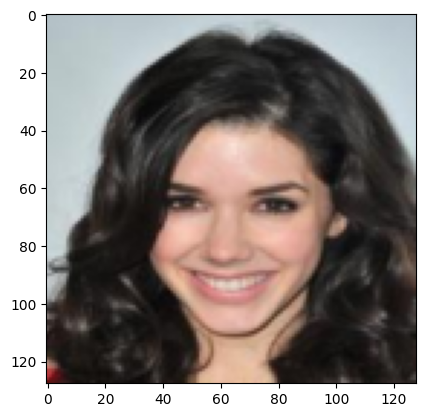

In [ ]:
images, labels = next(iter(train_loader2))

print(images[0].shape)
print(labels[0])
plt.imshow(images[0].permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
#plt.show()